## IMPORT

In [34]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


## LOAD DATASET

In [35]:
# Load dataset
file_path = 'RegresiUTSTelkom.csv'  # Pastikan file berada di folder yang sama
df = pd.read_csv(file_path, header=None)

# Buat nama kolom
columns = ['year'] + [f'x{i}' for i in range(1, df.shape[1])]
df.columns = columns

# Menampilkan 5 baris pertama untuk mendapatkan gambaran struktur dataset
print(df.head())

   year        x1        x2        x3        x4        x5        x6        x7  \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         x8        x9  ...       x81        x82       x83       x84       x85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

        x86        x87    

## PRE PROCESSING-DATA & FEATURE ENGINEERING

In [36]:
# Pilih subset fitur yang penting untuk polynomial (contoh: x1 hingga x5)
important_features = df.columns[1:6]  # Ambil 5 fitur pertama

# Feature engineering: Polynomial features pada fitur penting saja
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[important_features])

# Konversi polynomial features ke dataframe
df_poly = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(important_features))

# Gabungkan kembali ke dataset asli (tanpa semua fitur asli)
df = pd.concat([df['year'], df_poly], axis=1)

print(f"Shape dataset setelah preprocessing: {df.shape}")

Shape dataset setelah preprocessing: (515345, 21)


- 515345: Ini adalah jumlah baris dalam dataset. Setiap baris mewakili satu data point atau observasi dalam dataset.
- 21: Ini adalah jumlah kolom dalam dataset Anda setelah preprocessing. Kolom-kolom ini mencakup fitur asli, fitur yang dihasilkan dari polynomial features, dan kolom target (year).


## Exploratory Data Analysis (EDA) & Data Visualization

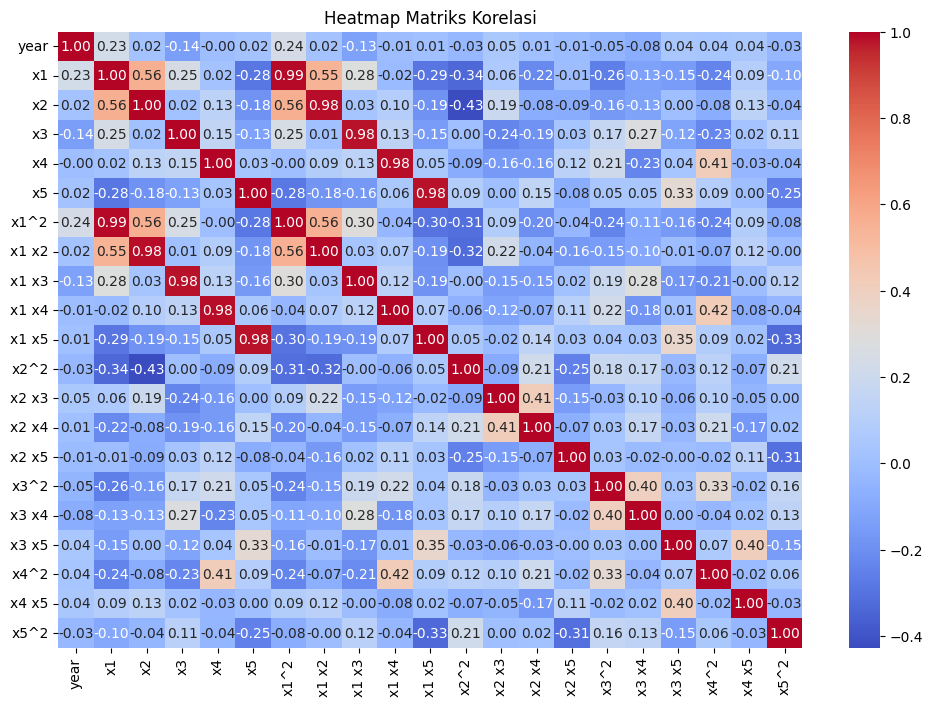

In [37]:
# Visualisasi heatmap korelasi
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap Matriks Korelasi")
plt.show()

- Heatmap: Fitur dengan korelasi tinggi terhadap target lebih relevan untuk model.

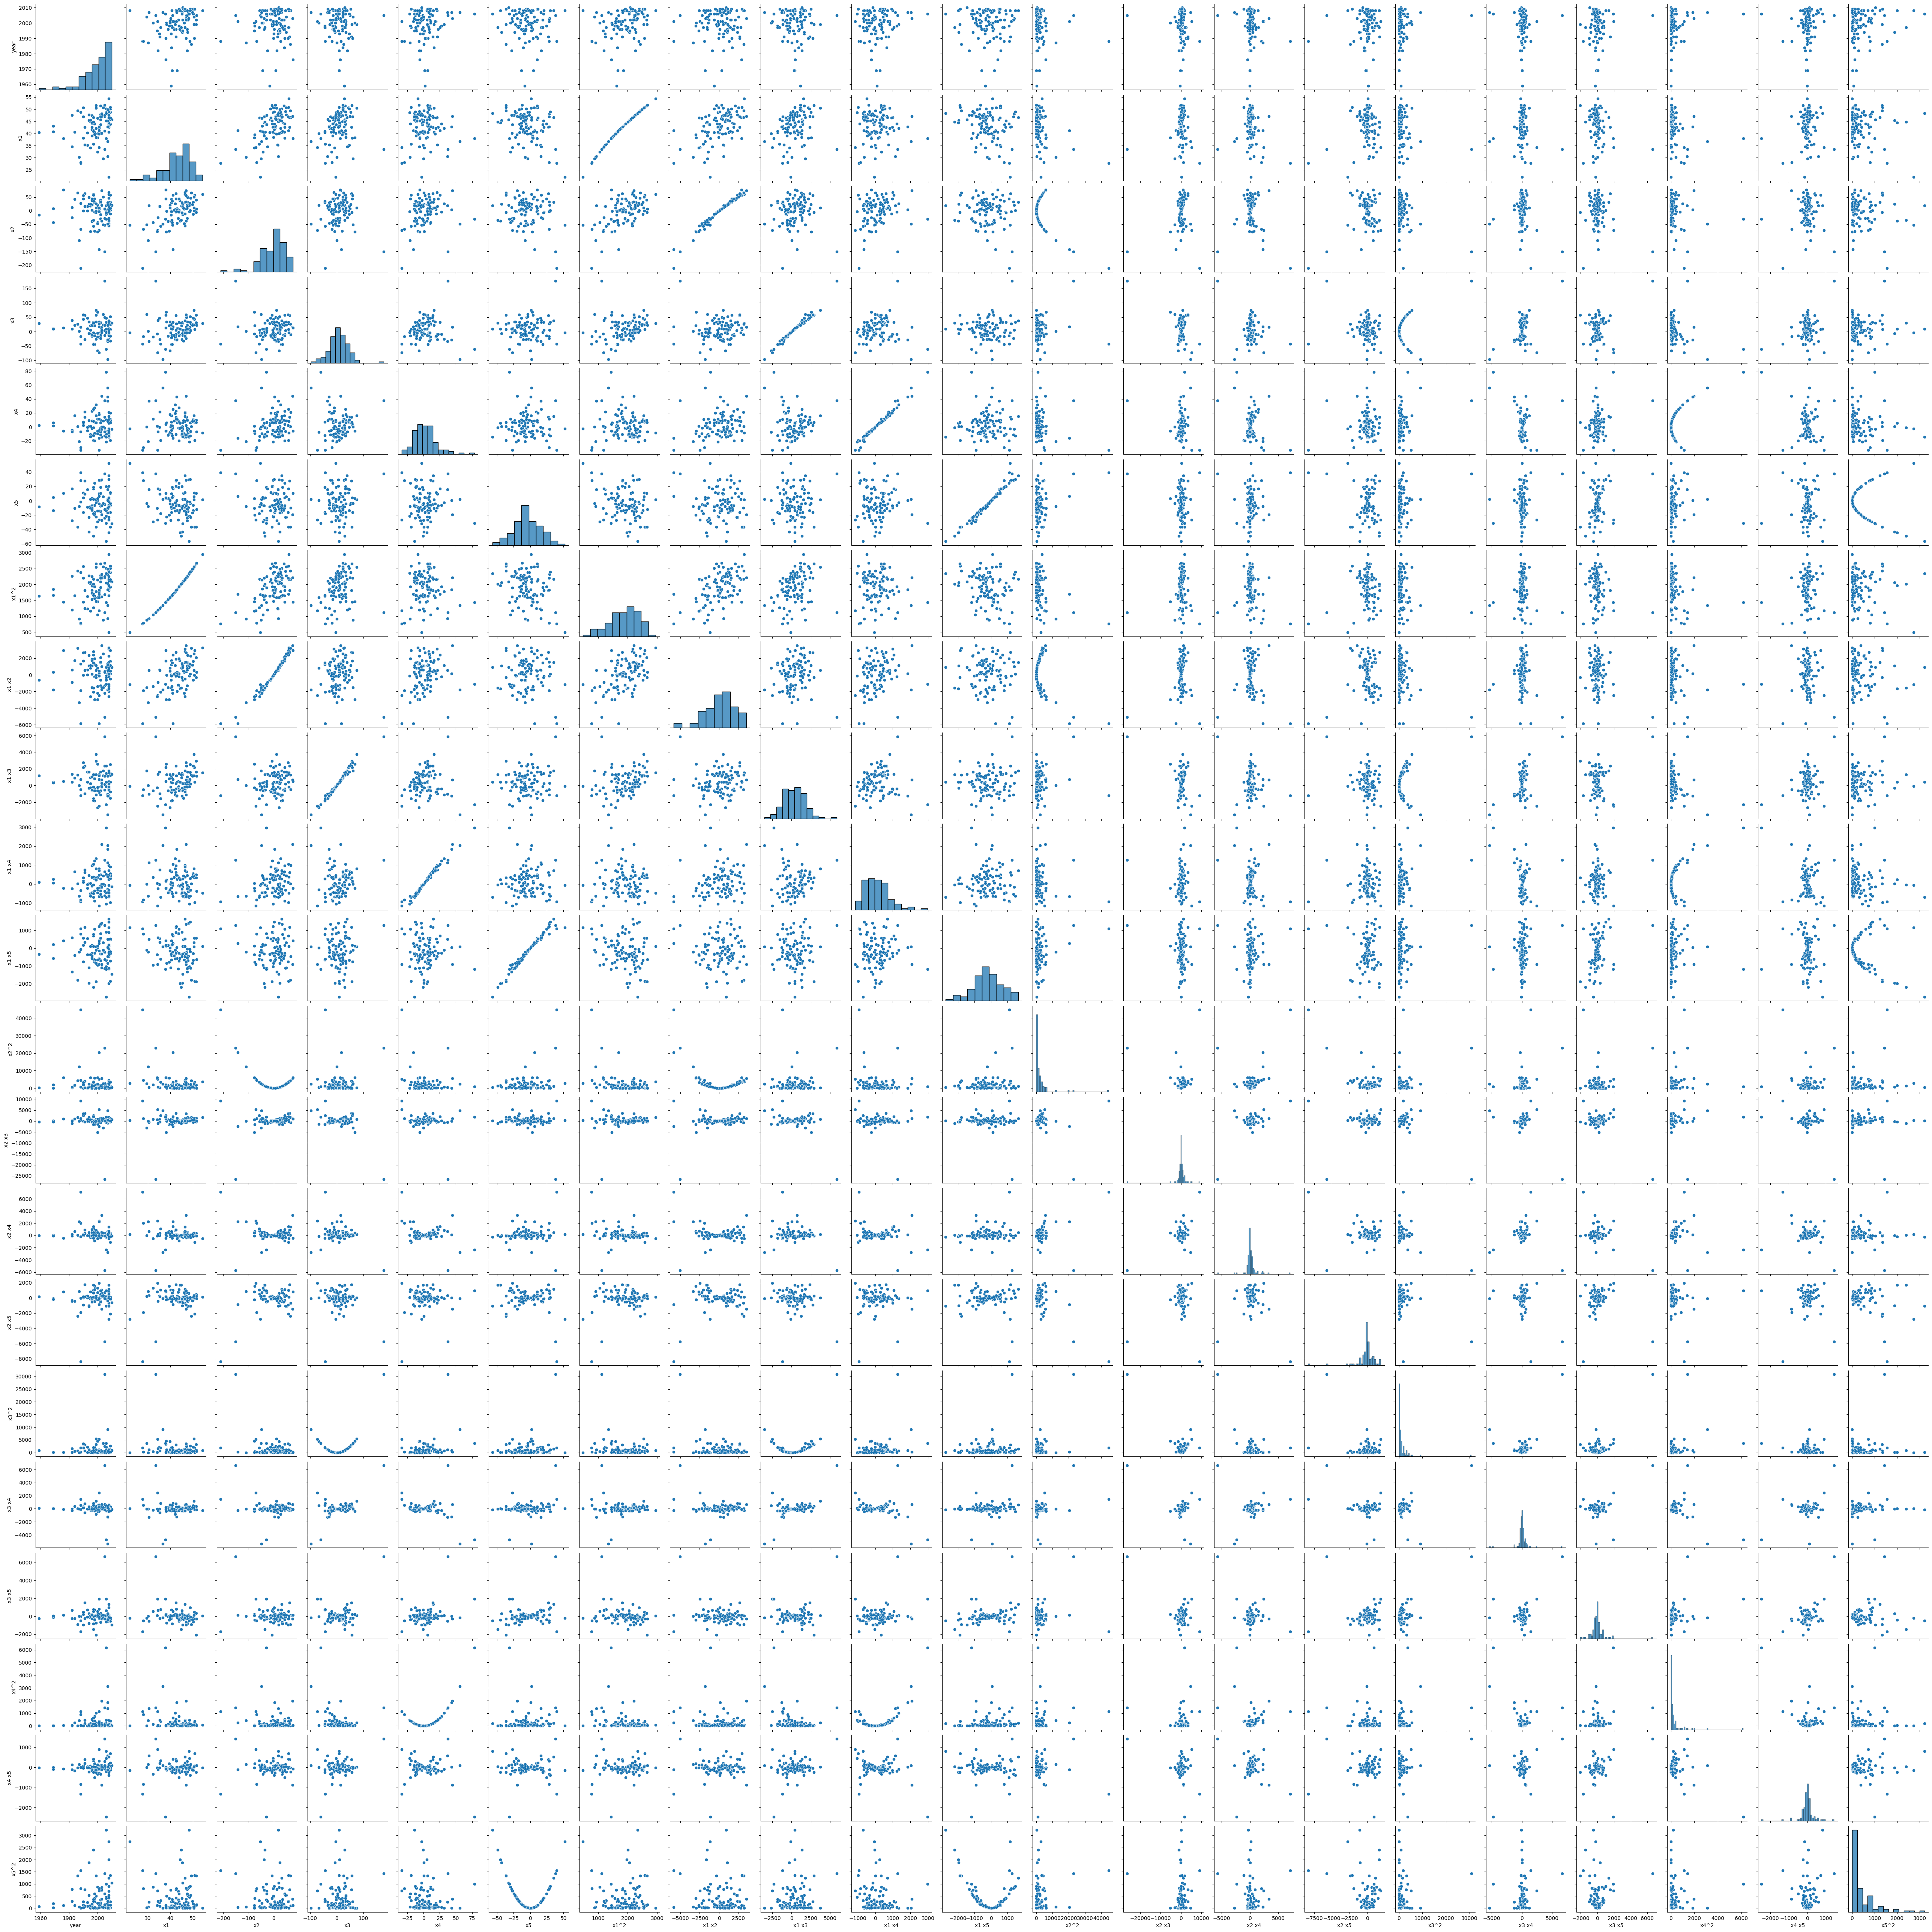

In [38]:
# Visualisasi scatter plot
sns.pairplot(df.sample(100))  # Sampling untuk efisiensi
plt.show()

- Scatter Plot: Menunjukkan apakah data target terdistribusi normal atau bias ke nilai tertentu.

## PIPELINE DENGAN SCKIT-LEARN

## Split dataset

In [39]:
# Pisahkan data menjadi fitur (X) dan target (y)
X = df.iloc[:, 1:]  # Semua kolom kecuali 'year'
y = df['year']

# Split data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 1. Polynomial Regression

In [40]:
pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),  # Standarisasi data
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Transformasi polynomial
    ('model', DecisionTreeRegressor(random_state=42))  # Decision Tree untuk prediksi
])

# Melatih model
pipeline_poly.fit(X_train, y_train)
y_pred_poly = pipeline_poly.predict(X_test)

# Evaluasi
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"[Polynomial Regression] MSE: {mse_poly:.2f}, R2 Score: {r2_poly:.2f}")


[Polynomial Regression] MSE: 202.46, R2 Score: -0.70


Insights:

- MSE (Mean Squared Error): Mengukur rata-rata kesalahan kuadrat antara nilai prediksi dan nilai aktual. Nilai lebih kecil menunjukkan prediksi yang lebih baik.
- R2 Score: Mengukur seberapa baik model menjelaskan variasi data target. Nilai mendekati 1 menunjukkan performa model yang baik.

## 2. Decision Tree

In [41]:
pipeline_tree = Pipeline([
    ('scaler', StandardScaler()),  # Standarisasi data
    ('model', DecisionTreeRegressor(random_state=42))  # Decision Tree Regressor
])

# Melatih model
pipeline_tree.fit(X_train, y_train)
y_pred_tree = pipeline_tree.predict(X_test)

# Evaluasi
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"[Decision Tree] MSE: {mse_tree:.2f}, R2 Score: {r2_tree:.2f}")


[Decision Tree] MSE: 199.60, R2 Score: -0.68


Insights:

- Decision Tree sering overfit pada data dengan fitur yang kompleks.
- Cocok untuk data dengan hubungan non-linear tetapi membutuhkan regularisasi.

## 3. k-NN Regression

In [42]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),  # Standarisasi data
    ('model', KNeighborsRegressor(n_neighbors=5))  # k-NN Regressor
])

# Melatih model
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)

# Evaluasi
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"[k-NN Regression] MSE: {mse_knn:.2f}, R2 Score: {r2_knn:.2f}")


[k-NN Regression] MSE: 113.47, R2 Score: 0.05


Insights:

- k-NN bekerja dengan baik pada dataset kecil atau ketika hubungan antar fitur lokal penting.
- Sensitif terhadap skala data, sehingga standarisasi menjadi langkah penting.

## 4. XGBoost Regression

In [43]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),  # Standarisasi data
    ('model', XGBRegressor(random_state=42))  # XGBoost Regressor
])

# Melatih model
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

# Evaluasi
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost Regression] MSE: {mse_xgb:.2f}, R2 Score: {r2_xgb:.2f}")


[XGBoost Regression] MSE: 96.68, R2 Score: 0.19


Insights:

- XGBoost adalah model berbasis ensemble yang unggul dalam menangani data kompleks dan menangkap hubungan non-linear.
- Biasanya memberikan performa terbaik jika dibandingkan dengan model lain.


## 5. Report

In [44]:
# Membuat laporan performa
results = {
    "Model": ["Polynomial Regression", "Decision Tree", "k-NN Regression", "XGBoost Regression"],
    "MSE": [mse_poly, mse_tree, mse_knn, mse_xgb],
    "R2 Score": [r2_poly, r2_tree, r2_knn, r2_xgb]
}

results_df = pd.DataFrame(results)
print(results_df)


                   Model         MSE  R2 Score
0  Polynomial Regression  202.461972 -0.701146
1          Decision Tree  199.597202 -0.677076
2        k-NN Regression  113.474899  0.046550
3     XGBoost Regression   96.682911  0.187641


## 7. Kesimpulan


Kesimpulan Berdasarkan Hasil Evaluasi Model
Berikut adalah analisis hasil evaluasi untuk keempat model berdasarkan nilai Mean Squared Error (MSE) dan R2 Score:

1. Polynomial Regression
MSE: 202.46 (tertinggi di antara semua model).
R2 Score: -0.70 (nilai negatif menunjukkan model tidak mampu menjelaskan variansi data dengan baik).
Analisis:

- Polynomial Regression tidak cocok untuk dataset ini. Kombinasi fitur polynomial yang terlalu banyak mungkin menyebabkan overfitting pada data latih tetapi gagal generalisasi pada data uji.
- Kemungkinan derajat polynomial terlalu tinggi, atau data memerlukan preprocessing tambahan untuk meningkatkan kinerjanya.

2. Decision Tree
MSE: 199.59 (hampir sama dengan Polynomial Regression, tetapi sedikit lebih baik).
R2 Score: -0.68 (masih negatif, menunjukkan performa buruk pada data uji).
Analisis:

- Decision Tree cenderung overfit pada dataset ini.
- Meskipun lebih baik dibandingkan Polynomial Regression, model ini juga tidak mampu menangkap pola yang relevan secara efektif.
- Parameter seperti kedalaman pohon (max_depth) atau minimal jumlah sampel perlu diatur melalui hyperparameter tuning.

3. k-NN Regression
MSE: 113.47 (penurunan signifikan dibandingkan Polynomial dan Decision Tree).
R2 Score: 0.05 (positif, menunjukkan model mulai dapat menjelaskan variansi data meskipun masih sangat lemah).
Analisis:

- k-NN menunjukkan performa yang lebih baik dibandingkan dua model sebelumnya.
- Karena sensitif terhadap jarak antar data, performanya meningkat setelah data distandarisasi.
- Model ini cocok untuk hubungan lokal antar fitur, tetapi mungkin memerlukan optimasi pada jumlah tetangga (n_neighbors) untuk hasil yang lebih baik.

4. XGBoost Regression
MSE: 96.68 (terendah di antara semua model, menunjukkan kesalahan prediksi yang paling kecil).
R2 Score: 0.19 (tertinggi, menunjukkan model mampu menjelaskan sekitar 19% variansi data).
Analisis:

- XGBoost adalah model dengan performa terbaik pada dataset ini. Kombinasi teknik ensemble dan kemampuannya menangani hubungan non-linear membuatnya unggul.
- Dengan hyperparameter tuning (misalnya, learning_rate, max_depth, dan n_estimators), performa XGBoost dapat lebih ditingkatkan.


Model Terbaik: XGBoost Regression adalah model yang paling cocok untuk dataset ini, dengan MSE terendah dan R2 Score tertinggi.

# HYPERPARAMETER TUNING PADA SETIAP MODEL

## 1. Polynomial Regression

In [45]:
# Hyperparameter tuning untuk Polynomial Regression
param_poly = {
    'poly__degree': [2],  # Tetap di derajat rendah untuk efisiensi
    'model__max_depth': [5, 10]  # Kombinasi kedalaman pohon
}

grid_poly = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias=False)),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    param_poly,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_poly.fit(X_train, y_train)

# Evaluasi
best_poly = grid_poly.best_estimator_
y_pred_poly = best_poly.predict(X_test)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"[Polynomial Regression] Best Params: {grid_poly.best_params_}")
print(f"[Polynomial Regression] MSE: {mse_poly:.2f}, R2 Score: {r2_poly:.2f}")


c:\Users\bagus\miniconda3\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[Polynomial Regression] Best Params: {'model__max_depth': 10, 'poly__degree': 2}
[Polynomial Regression] MSE: 100.12, R2 Score: 0.16


## 2. Decision Tree

In [46]:
# Hyperparameter tuning untuk Decision Tree
param_tree = {
    'model__max_depth': [5, 10, None],  # Kedalaman pohon
    'model__min_samples_split': [2, 5]  # Minimum data per split
}

grid_tree = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    param_tree,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_tree.fit(X_train, y_train)

# Evaluasi
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"[Decision Tree] Best Params: {grid_tree.best_params_}")
print(f"[Decision Tree] MSE: {mse_tree:.2f}, R2 Score: {r2_tree:.2f}")


[Decision Tree] Best Params: {'model__max_depth': 10, 'model__min_samples_split': 5}
[Decision Tree] MSE: 99.57, R2 Score: 0.16


## 3. k-NN Regression

In [47]:
# Hyperparameter tuning untuk k-NN Regression
param_knn = {
    'model__n_neighbors': [3, 5],  # Tetangga terdekat
    'model__weights': ['uniform', 'distance']  # Metode pembobotan
}

grid_knn = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor())
    ]),
    param_knn,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)

# Evaluasi
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"[k-NN Regression] Best Params: {grid_knn.best_params_}")
print(f"[k-NN Regression] MSE: {mse_knn:.2f}, R2 Score: {r2_knn:.2f}")


[k-NN Regression] Best Params: {'model__n_neighbors': 5, 'model__weights': 'uniform'}
[k-NN Regression] MSE: 113.47, R2 Score: 0.05


## 4. XGBoost Regression

In [48]:
# Hyperparameter tuning untuk XGBoost Regression
param_xgb = {
    'model__n_estimators': [100],  # Jumlah pohon
    'model__max_depth': [3, 5],  # Kedalaman pohon
    'model__learning_rate': [0.1]  # Kecepatan pembelajaran
}

grid_xgb = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42))
    ]),
    param_xgb,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

# Evaluasi
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost Regression] Best Params: {grid_xgb.best_params_}")
print(f"[XGBoost Regression] MSE: {mse_xgb:.2f}, R2 Score: {r2_xgb:.2f}")


[XGBoost Regression] Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
[XGBoost Regression] MSE: 96.23, R2 Score: 0.19


## KESIMPULAN

In [49]:
# Membuat laporan hasil hyperparameter tuning dan evaluasi model
results = {
    "Model": ["Polynomial Regression", "Decision Tree", "k-NN Regression", "XGBoost Regression"],
    "Best Parameters": [
        grid_poly.best_params_,
        grid_tree.best_params_,
        grid_knn.best_params_,
        grid_xgb.best_params_,
    ],
    "MSE": [mse_poly, mse_tree, mse_knn, mse_xgb],
    "R2 Score": [r2_poly, r2_tree, r2_knn, r2_xgb],
}

# Membuat DataFrame hasil
results_df = pd.DataFrame(results)
print(results_df)

                   Model                                    Best Parameters  \
0  Polynomial Regression        {'model__max_depth': 10, 'poly__degree': 2}   
1          Decision Tree  {'model__max_depth': 10, 'model__min_samples_s...   
2        k-NN Regression  {'model__n_neighbors': 5, 'model__weights': 'u...   
3     XGBoost Regression  {'model__learning_rate': 0.1, 'model__max_dept...   

          MSE  R2 Score  
0  100.118780  0.158772  
1   99.573058  0.163357  
2  113.474899  0.046550  
3   96.230511  0.191442  


1. Polynomial Regression
Best Parameters: {'model__max_depth': 10, 'poly__degree': 2}
MSE: 100.12 (cukup baik, namun tidak terbaik).
R2 Score: 0.16 (masih rendah, model hanya menjelaskan 16% dari variansi data).

2. Decision Tree
Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 5}
MSE: 99.57 (lebih baik dari Polynomial Regression).
R2 Score: 0.16 (sebanding dengan Polynomial Regression).

3. k-NN Regression
Best Parameters: {'model__n_neighbors': 5, 'model__weights': 'uniform'}
MSE: 113.47 (tertinggi di antara semua model, menunjukkan kesalahan prediksi yang besar).
R2 Score: 0.05 (paling rendah, hanya menjelaskan 5% dari variansi data).

4. XGBoost Regression
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
MSE: 96.23 (terendah di antara semua model, menunjukkan performa prediksi terbaik).
R2 Score: 0.19 (tertinggi, menjelaskan 19% dari variansi data).

# KESIMPULAN AKHIR
Gunakan XGBoost sebagai Model Akhir: Dengan performa terbaik, XGBoost menunjukkan hasil paling konsisten. XGBoost Terbaik di antara semua model
